In [1]:
from io import StringIO
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
import matplotlib.gridspec as gridspec
import statsmodels.stats.stattools as st
import statsmodels.stats.diagnostic as diag 

In [29]:
def showPlot(df, title, size = 24):
    global leftovers
    # create figure
    fig = plt.figure(tight_layout=True) 
    gs = gridspec.GridSpec(3, 1)
    # add upper subplot
    ax = fig.add_subplot(gs[0:2,0])
    # get data
    x = df['x'].values
    y = df['y'].values
    # plot original data
    ax.plot(x, y,'r^')
    # use least squares method
    p1 = np.polyfit(x, y, deg = 1)
    f = np.poly1d(p1)
    points = np.linspace(x.min()-1, x.max()+1, 100)
    # plot least squares approximation
    ax.plot(points, f(points), 'g-.')
    ax.grid()
    ax.legend(['Данные','Метод Наим. Кв.'])
    
    r = df.corr()['x']['y']
    plt.title(f'{title}, r = {round(r,3)}')
    
    # calculate leftovers
    ax = fig.add_subplot(gs[2,0])
    leftovers = (y - f(x))
    
    numberOfBins = int(1 + np.ceil(3.322 * np.log10(len(leftovers))))
    counts, bins = np.histogram(leftovers, numberOfBins, density=True)

    ax.hist(bins[:-1], bins, weights=counts, color='m', alpha=0.5, linewidth=1.5, edgecolor='k')
    ax.grid()
    
    pvalueIsNormal = sp.stats.shapiro(leftovers).pvalue
    plt.title('Гистограмма остатков,\n' +
              'при условии, что данные имеют нормальное распеределение,\n' +
              'веротность получить такие же отклонения или больше: ' +
              f'p = {round(pvalueIsNormal, 3)}')
    plt.show()
    print(f'По критерию Шапиро-Уилка остатки носят {"НЕ " if pvalueIsNormal < 0.05 else ""}нормальный характер')
    print(f'Среднее остатков: {leftovers.mean().round(3)}')
    print(f'Дисперсия остатков: {leftovers.std().round(3)} =? const')
    print(f'Автокореляция остаков (Дарбин-Уотсон): {np.interp(st.durbin_watson(leftovers),[0,4],[1,-1]).round(3)} (от -1 до 1)')
    acorrPvalue = diag.acorr_lm(leftovers)[3]
    print(f'Автокореляция остаков (тест множителей Лагранжа): {"ЕСТЬ" if acorrPvalue < 0.05 else "НЕТ"} (p = {round(acorrPvalue, 3)})')
    print(f'Кореляция остатков с \'х\': { np.corrcoef([df["x"],leftovers])[0,1].round(3)}')
    
    print('----------------------------------')
    ###print(f'Коэф. детерминации R^2: {1 - leftovers.std()/y.std()}') неверно!
    dN = leftovers.size-1
    print(f'Коэф. детерминации2 R^2: {1 - (leftovers**2).sum()/y.var(ddof=dN)}') # на самом деле равен коэф. корреляции в квадрате
    
    De = leftovers.std()/1
    Dy = y.std()/(y.size - 1)
    f_statistic = Dy/De
    p_value = 1 - sp.stats.f.cdf(f_statistic, 1 , y.size -1)
    print(f'По критерию Фишера коэф. детерминации значимо {"НЕ " if p_value < 0.05 else ""}отличается от нуля')
    
    # y = ax + b
    # проверка значимости коэф. а регрессионной модели
    ua = np.sqrt(leftovers.var(ddof=2) * (x**2).sum() / x.size / x.var(ddof = dN))
    # проверка значимости коэф. b регрессионной модели
    ub = np.sqrt(leftovers.var(ddof=2) / x.var())

# <i> Исследование корреляцонной взаимосвязи связи между двумя величинами  и зависимость  одной величины от другой

импорт и преобразование данных в удобный для работы формат

In [25]:
data = StringIO('''№		1	2	3	4	5	6	7	8	9	10
7	x	36	28	43	52	51	54	25	37	51	29
	y	85	60	99	117	118	125	56	86	115	68''')

In [26]:
df = pd.read_csv(data, sep = '	').fillna(method = 'ffill')

In [27]:
panel3D = {}
for i in range(0,len(df),2):
    panel3D[df.loc[i]['№']] = df.loc[i:i+1][df.columns[2:]]

## Нанесём на графики точки от каждого эсперимента отдельно

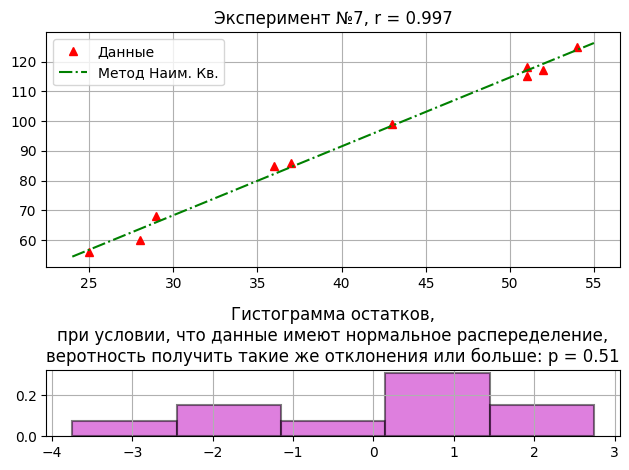

По критерию Шапиро-Уилка остатки носят нормальный характер
Среднее остатков: -0.0
Дисперсия остатков: 1.991 =? const
Автокореляция остаков (Дарбин-Уотсон): -0.449 (от -1 до 1)
Автокореляция остаков (тест множителей Лагранжа): НЕТ (p = 0.296)
Кореляция остатков с 'х': -0.0
----------------------------------
Коэф. детерминации2 R^2: 0.9933293411804387
По критерию Фишера коэф. детерминации значимо отличается от нуля


In [30]:
key = 7
newDf = pd.DataFrame(panel3D[key].T.values, columns = ['x','y'])
showPlot(newDf,f'Эксперимент №{round(key)}')